In [1]:
import numpy as np
import itertools
import sys
sys.path.append("..")

In [2]:
from utility_functions import (calculate_model_performance,
                               plot_ROC)

In [3]:
def get_shapes(any_):
    for array in any_:
        try:
            print(array.shape)
        except:
            print("NONE")
    print("\n")

In [4]:
# ============= ACTIVATION FUNCTIONS ===============#

def sigmoid(Z, prime=False):
    # np.
    if prime:
        return sigmoid(Z) * (1 - sigmoid(Z))
    return 1 / (1 + np.exp(-Z))


def linear(Z, prime=False):
    if prime:
        return np.ones_like(Z)
    return Z


def relu(Z, alpha=0.01, prime=False):
    if prime:
        Z_relu = np.ones_like(Z, dtype=np.float64)
        Z_relu[Z < 0] = alpha
        return Z_relu
    return np.where(Z < 0, alpha * Z, Z)


def tanh(Z, prime=False):
    # np.tanh() could be used directly to speed this up
    if prime:
        return 1 - np.power(tanh(Z), 2)
    return (2 / (1 + np.exp(-2 * Z))) - 1


def elu(Z, prime=False):
    # https://mlfromscratch.com/activation-functions-explained/#/
    alpha = 0.2
    if prime:
        return np.where(Z < 0, alpha * (np.exp(Z)), 1)
    return np.where(Z < 0, alpha * (np.exp(Z) - 1), Z)


def softmax(Z, prime=False):
    # https://deepnotes.io/softmax-crossentropy
    # max(Z) term is added to stabilise the function.
    exps = np.exp(Z - np.max(Z))
    return exps / np.sum(exps, axis=0)

In [5]:
# ============== LOSS FUNCTIONS ===============#

# https://deepnotes.io/softmax-crossentropy
EPSILON = 1e-8

def calculate_error(Y, Y_hat):
    # Y and Y_hat should be in the form of (no_of_classes, no_of_training_examples)
    m = Y.shape[1]
    return -np.sum(Y * np.log(Y_hat + EPSILON)) / m

In [40]:
# References
# https://mc.ai/multilayered-neural-network-from-scratch-using-python/
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
# https://www.coursera.org/learn/machine-learning/home/week/5
# https://www.coursera.org/specializations/deep-learning
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network.py
# https://github.com/JWarmenhoven/Coursera-Machine-Learning

class NeuralNetwork:
    

    def __init__(
        self,
        input_layer: tuple,
        hidden_layer: list, # list of tuples
        output_layer: int,
        batch_size: int,
        alpha: float,
        epoch: int,
        random_state: int,
        verbose=True,
        metrics="accuracy"
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.mini_batch_size = batch_size
        self.alpha = alpha
        self.epoch = epoch
        self.seed = random_state
        self.verbose = verbose
        self.metrics = metrics
        
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.layers = len(self.weight_set_dimensions) + 1


    def get_A(self, X):
        A, _ = self.forwardpass(X)
        return A
    
    def get_Z(self, X):
        _, Z = self.forwardpass(X)
        return Z
    
    def display_information(self, X, Y, epoch_no):
        model_performance_metrics = calculate_model_performance(
            np.argmax(Y, axis=0),
            self.predict(X)
        )
        print("%s: %.10f - epoch %s    iteration %s - loss %.20f" %(
                self.metrics,
                model_performance_metrics[self.metrics],
                epoch_no,
                self.no_of_iterations,
                calculate_error(Y,
                                self.get_A(X)[-1])
            )
        )


    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []
        
        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

        
    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions


    def initialise_weights(self):

        self.W = np.empty_like(range(self.layers), dtype=object)
        self.B = np.empty_like(range(self.layers), dtype=object)
        self.W[0] = None
        self.B[0] = None
        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            np.random.seed(self.seed)
            self.W[layer] = np.random.rand(y, x)
            self.B[layer] = np.random.rand(y, 1)


    def forwardpass(self, X):
        Z = np.empty_like(range(self.layers), dtype=object)
        A = np.empty_like(range(self.layers), dtype=object)
        A[0] = X
        Z[0] = None
        for layer in range(1, self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer])"
            
            Z[layer] = self.W[layer] @ A[layer - 1] + self.B[layer]
            A[layer] = eval(active_function + arg_to_pass_to_eval)
        return A, Z
            

    def backpropagation(self, Y, A, Z):
        self.delta = np.empty_like(range(self.layers), dtype=object)
        self.delta[0] = None

        self.gradient_W = np.empty_like(range(self.layers), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None
        
        self.delta[-1] = A[-1] - Y
        
        # We substract 1 here as delta_final is calculated seperately above
        for layer in reversed(range(1, self.layers - 1)):
            # 1 is substracted from layer as activations_functions start indexing from 0
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer], prime=True)"

            self.delta[layer] = (
                self.W[layer + 1].T @ self.delta[layer + 1] *
                eval(active_function + arg_to_pass_to_eval)
            ) 

        # calculate the gradient
        for layer in range(1, self.layers):
            self.gradient_W[layer] = (self.delta[layer] @ A[layer - 1].T) / self.m
            self.gradient_B[layer] = np.sum(self.delta[layer], axis=1, keepdims=True) / self.m

        #update the weights
        for layer in range(1, self.layers):
            self.W[layer] -= self.alpha * self.gradient_W[layer]
            self.B[layer] -= self.alpha * self.gradient_B[layer]
            
            
    def fit(self, X, Y):
        self.initialise_weights()
        
        # By default the method is SGD(Stochastic Gradient Descent) if one wishes to use
        # the whole batch, simply pass the number of traning examples available as the
        # batch size when instantiating the class
        self.no_of_iterations = 0
        shuffled = np.arange(self.m)
        if self.verbose:
            print("Initialising weights...")
            print("Starting the training...")
            print("Initial cost: %.10f\n" %calculate_error(Y,self.get_A(X)[-1]))
        for epoch_no in range(1, self.epoch + 1):
            np.random.shuffle(shuffled)
            X_shuffled = X[:, shuffled]
            Y_shuffled = Y[:, shuffled]
            for i in range(0, self.m, self.mini_batch_size):
                self.no_of_iterations += 1
                X_mini_batch = X_shuffled[:, i: i + self.mini_batch_size]
                Y_mini_batch = Y_shuffled[:, i: i + self.mini_batch_size]

                A, Z = self.forwardpass(X_mini_batch)
                self.backpropagation(Y_mini_batch, A, Z)
                if self.no_of_iterations % 5000 == 0 and self.verbose:
                    self.display_information(X, Y, epoch_no)


    def predict(
        self,
        X: np.ndarray,
        return_prob_matrix=False
    ):
        """Predict the output given the training data.

            Returns the predicted values in two forms:

            1.either by picking up the highest value along the columns for every row,
                i.e. "np.argmax(self.A[-1].T, axis=1)"
            2.or by returning a matrix that is in the shape of Y.T where each column
                represents the probability of the instance belonging to that class.
                Please note that every column in Y.T represents a class. To be able to
                return the probability matrix, the final activation function must be
                softmax!
                i.e. "array([0.9650488423, 0.0354737543, 0.0005225966])"

        Args:
            X (numpy.ndarray): Training set in the shape of
                (no_of_features, no_of_training examples).
            return_prob_matrix (bool, optional): Returns the probability matrix if True.
                Defaults to False.
        
        Returns:
            numpy.ndarray:
            
            if return_prob_matrix is False, the output is in the shape of
                (no_of_training_examples, 1)
            if return_prob_matrix is True, the output is in the shape of
                (no_of_training_examples, no_of_features)
        """
        A, Z = self.forwardpass(X)
        if return_prob_matrix and self.activation_functions[-1] == "softmax":
            np.set_printoptions(precision=10, suppress=True)
            return A[-1].T
        return np.argmax(A[-1].T, axis=1)

# Testing with benchmark datasets

## 1.Iris Dataset

In [41]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data[:,[0,2]].T
y = data.target
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
Y = Y.T

In [42]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


In [43]:
model = NeuralNetwork(
    input_layer=(2, "relu"),
    hidden_layer=[(4, "relu"),
                  (4, "softmax")],
    output_layer=3,
    batch_size=64,
    alpha=0.5,
    epoch=5000,
    random_state=42
)

model.fit(X, Y)

Initialising weights...
Starting the training...
Initial cost: 0.6657951312

relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
rel

relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu
relu


In [29]:
model.predict(X) == np.argmax(Y, axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,

In [16]:
model_performance_metrics = calculate_model_performance(
    np.argmax(Y, axis=0),
    model.predict(X)
)

In [17]:
model_performance_metrics

{'specificty': 97.99999999901999,
 'sensitivity/recall': 93.99999999812,
 'accuracy': 96.66666666602222,
 'prevalence': 33.33333333311111,
 'precision': 95.91836734498128,
 'F1': 94.94949494707684,
 'false_positive_rate': 1.99999999998}

Text(0, 0.5, 'petal length')

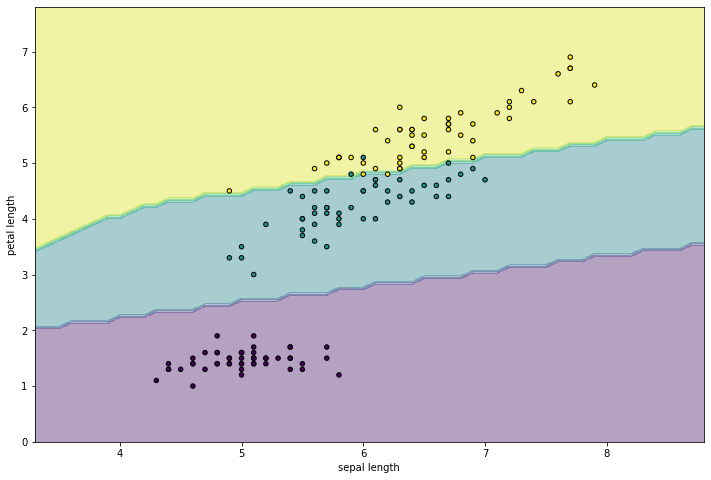

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

## 2.Make Moons dataset

In [14]:
from sklearn.datasets import make_moons
from sklearn import preprocessing

x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
y_next = np.where(y==0,1,0)
Y = Y.T
Y = list(Y)
Y.append(y_next)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(2, 1500)
(2, 1500)


In [15]:
model = NeuralNetwork(
    input_layer=(2, "sigmoid"),
    hidden_layer=[(8, "tanh"),
                  (6, "relu"),
                  (4, "softmax")],
    output_layer=2,
    batch_size=64,
    loss_function="categorical_crossentropy",
    alpha=0.5,
    epoch=5000,
    random_state=42
)


model.fit(X, Y)

Initialising weights...
Starting the training...
Initial cost: 2.3781080561

accuracy: 50.0000000000 - epoch 209    iteration 5000 - loss 0.69323844108674737008
accuracy: 50.0000000000 - epoch 417    iteration 10000 - loss 0.69407146248662743293
accuracy: 50.0000000000 - epoch 625    iteration 15000 - loss 0.69344240311569105284
accuracy: 50.0000000000 - epoch 834    iteration 20000 - loss 0.69325074074594827955
accuracy: 50.0000000000 - epoch 1042    iteration 25000 - loss 0.69451563903272883760
accuracy: 50.0000000000 - epoch 1250    iteration 30000 - loss 0.69341381823073733326
accuracy: 50.0000000000 - epoch 1459    iteration 35000 - loss 0.69333743290764082712
accuracy: 50.0000000000 - epoch 1667    iteration 40000 - loss 0.69317514042104755312
accuracy: 50.4666666666 - epoch 1875    iteration 45000 - loss 0.69287455487443938562
accuracy: 77.1333333333 - epoch 2084    iteration 50000 - loss 0.68800075890693279668
accuracy: 88.3999999999 - epoch 2292    iteration 55000 - loss 0.248

Text(0.5, 1.0, 'Decision Boundaries')

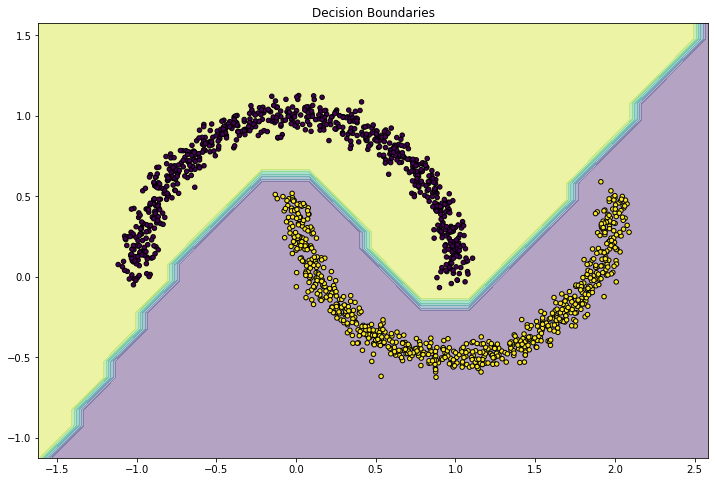

In [16]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 0.5, dt[:, 0].max() + 0.5
y_min, y_max = dt[:, 1].min() - 0.5, dt[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries')

## 3.Andrew NG Assignment 2 Dataset

In [17]:
ex2data2 = np.loadtxt("../ex2/data/ex2data2.txt", delimiter=",")

X = ex2data2[:, :-1]
y = ex2data2[:, -1]

X = X.T
Y = y.T

In [18]:
import pandas as pd

Y = pd.get_dummies(Y).values.T

In [19]:
print(X.shape)
print(Y.shape)

(2, 118)
(2, 118)


In [20]:
model = NeuralNetwork(
    input_layer=(2, "sigmoid"),
    hidden_layer=[(8, "tanh"),
                  (6, "relu"),
                  (4, "sigmoid")],
    output_layer=2,
    batch_size=64,
    loss_function="categorical_crossentropy",
    alpha=0.8,
    epoch=25000,
    random_state=42
)

model.fit(X, Y)

Initialising weights...
Starting the training...
Initial cost: 0.0068215365

accuracy: 50.8474576267 - epoch 2500    iteration 5000 - loss 0.69293762148423276859
accuracy: 50.8474576267 - epoch 5000    iteration 10000 - loss 0.69288832185828419519
accuracy: 54.2372881351 - epoch 7500    iteration 15000 - loss 0.67467913672497448196
accuracy: 76.2711864400 - epoch 10000    iteration 20000 - loss 0.49919616772402264360
accuracy: 83.8983050840 - epoch 12500    iteration 25000 - loss 0.38595347436121507645
accuracy: 84.7457627111 - epoch 15000    iteration 30000 - loss 0.33089837132739396974
accuracy: 89.8305084738 - epoch 17500    iteration 35000 - loss 0.28106235318020894587
accuracy: 88.9830508467 - epoch 20000    iteration 40000 - loss 0.27111189133384594463
accuracy: 88.9830508467 - epoch 22500    iteration 45000 - loss 0.26462454374181981764
accuracy: 91.5254237280 - epoch 25000    iteration 50000 - loss 0.23824722669616488213


In [21]:
model_performance_metrics = calculate_model_performance(
    np.argmax(Y, axis=0),
    model.predict(X)
)

model_performance_metrics

{'specificty': 93.33333333177778,
 'sensitivity/recall': 89.65517241224732,
 'accuracy': 91.52542372803791,
 'prevalence': 49.15254237246481,
 'precision': 92.8571428554847,
 'F1': 91.22807017333825,
 'false_positive_rate': 6.666666666555556}

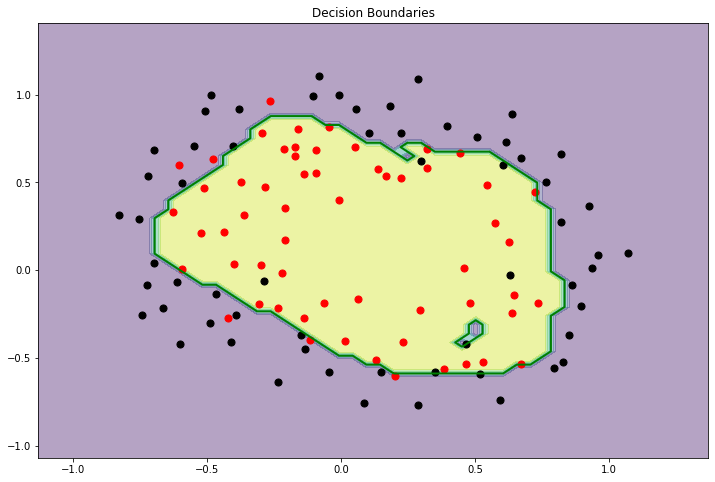

In [22]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
X = ex2data2

x1_min, x1_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3,
x2_min, x2_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3,
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T) 

negatives = ex2data2[ex2data2[:, -1] == 0]
positives = ex2data2[ex2data2[:, -1] == 1]

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(negatives[:, 0], negatives[:, 1],s=50, color='k')
plt.scatter(positives[:, 0], positives[:, 1],s=50, color='r')
plt.title('Decision Boundaries')

plt.contour(xx1, xx2, Z, [0.5], linewidths=2, colors="g")

# MNIST dataset

In [19]:
from scipy.io import loadmat
data = loadmat('../ex3/data/ex3data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [20]:
X = data["X"].T

lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(data["y"]).T

In [21]:
print(X.shape)
print(Y.shape)

(400, 5000)
(10, 5000)


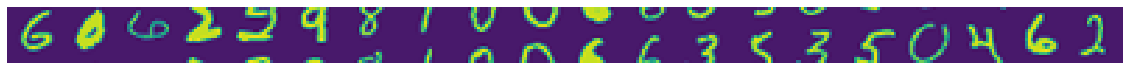

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

sample = np.random.choice(data["X"].shape[0], 20)
ax.imshow(data["X"][sample,1:].reshape(-1,20).T)
ax.axis('off');

In [25]:
model = NeuralNetwork(
    input_layer=(X.shape[0], "sigmoid"),
    hidden_layer=[(30, "sigmoid"),
                  (10, "softmax")],
    output_layer=Y.shape[0],
    batch_size=10,
    alpha=3,
    epoch=100,
    random_state=12
)


model.fit(X, Y)

Initialising weights...
Starting the training...
Initial cost: 0.4793073057

accuracy: 10.0000000000 - epoch 10    iteration 5000 - loss 0.45004532208397751702
accuracy: 10.0000000000 - epoch 20    iteration 10000 - loss 0.45005535267220603268
accuracy: 10.0000000000 - epoch 30    iteration 15000 - loss 0.45009223354648836279
accuracy: 10.0000000000 - epoch 40    iteration 20000 - loss 0.45005050779974964392
accuracy: 10.0000000000 - epoch 50    iteration 25000 - loss 0.45005180482261003538
accuracy: 10.0000000000 - epoch 60    iteration 30000 - loss 0.45004983177505381020
accuracy: 10.0000000000 - epoch 70    iteration 35000 - loss 0.45008662301244495296
accuracy: 10.0000000000 - epoch 80    iteration 40000 - loss 0.45011176473438296863
accuracy: 10.0000000000 - epoch 90    iteration 45000 - loss 0.45006394284773032499
accuracy: 10.0000000000 - epoch 100    iteration 50000 - loss 0.45007446275103996092


In [28]:
model.predict(X)

array([6, 6, 6, ..., 6, 6, 6])

In [29]:
np.argmax(Y,axis=0)

array([9, 9, 9, ..., 8, 8, 8])

In [30]:
np.sum(model.predict(X)  == np.argmax(Y,axis=0))

500